In [8]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [164]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import grad, vmap
from multipledispatch import dispatch
import jax.config

jax.config.update("jax_enable_x64", True)
from typing import Callable

key = jr.PRNGKey(123)

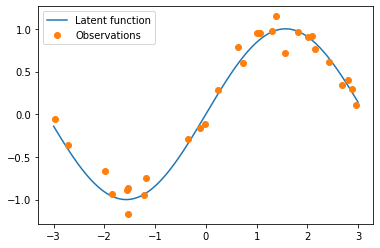

In [165]:
n = 30
x = jr.uniform(key, shape=(n,), minval=-3.0, maxval=3.0).sort()
f = lambda x: jnp.sin(x)
signal = f(x)
noise = jr.normal(key, signal.shape) * 0.1
y = signal + noise

xtest = jnp.linspace(-3.0, 3.0, 500)
ytest = f(xtest)

plt.plot(xtest, ytest, label="Latent function")
plt.plot(x, y, "o", label="Observations")
plt.legend(loc="best")

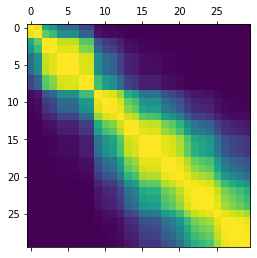

In [166]:
def compute_gram(
    func: Callable, x: jnp.array, y: jnp.array, jitter: float = 1e-6
) -> jnp.array:
    K = vmap(lambda x1: vmap(lambda y1: func(x1, y1))(y))(x)
    if x.shape[0] == y.shape[0]:
        jitter_mat = jnp.eye(x.shape[0]) * jitter
        K += jitter_mat
    return K


def rbf(lengthscale: float, variance: float) -> Callable:
    def kernel(x, y):
        tau = jnp.square(x - y)
        return jnp.square(variance) * jnp.exp(-tau / (2 * jnp.square(lengthscale)))

    return kernel


kernel_fn = rbf(1.0, 1.0)
K = compute_gram(kernel_fn, x, x)
plt.matshow(K)

# Mean function

In [167]:
# Exposed fn
def zero_mean(x: jnp.array):
    return jnp.zeros_like(x)

# Prior samples

In [170]:
mu = zero_mean(x)
samples = jr.multivariate_normal(key, mu, K, shape=(20,))

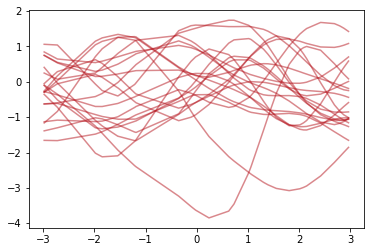

In [171]:
plt.plot(x, samples.T, color="#B5121B", alpha=0.5)
plt.show()

# Sample from the posterior

We can also condition on the observations and sample from the posterior. The posterior us uniquely characterised by a conditional mean and conditional variance, so we'll have a function for each of these.

In [242]:
class Kernel:
    def __init__(self, name: str = None):
        self.name = name

    def fun(self, x: jnp.array, y: jnp.array) -> jnp.array:
        raise NotImplementedError

    def update(self, params: dict):
        raise NotImplementedError

    def __call__(self, x: jnp.array, y: jnp.array, jitter: float = 1e-6) -> jnp.array:
        raise NotImplementedError


class Stationary(Kernel):
    def __init__(self, name="Stationary"):
        super().__init__(name=name)

    def __call__(
        self,
        x: jnp.array,
        y: jnp.array,
        params: dict,
        jitter: float = 1e-6,
    ) -> jnp.array:
        K = vmap(lambda x1: vmap(lambda y1: self.fun(x1, y1, params))(y))(x)
        if x.shape[0] == y.shape[0]:
            jitter_mat = jnp.eye(x.shape[0]) * jitter
            K += jitter_mat
        return K


class RBF(Stationary):
    def __init__(self, name: str = "RBF"):
        super().__init__(name)

    def fun(self, x: jnp.array, y: jnp.array, params: dict) -> jnp.array:
        tau = jnp.square(x - y)
        return jnp.square(params["variance"]) * jnp.exp(
            -tau / (2 * jnp.square(params["lengthscale"]))
        )

In [243]:
class MeanFunction:
    def __init__(self, name: str = None):
        self.name = name

    def __call__(self, x: jnp.array) -> jnp.array:
        raise NotImplementedError


class Zero:
    def __init(self, name="Zero"):
        self.name = name

    def __call__(self, x: jnp.array) -> jnp.array:
        return jnp.zeros_like(x)

In [244]:
class Likelihood:
    def __init__(self, name: str = None):
        self.name = name

    def update(self, params: dict):
        raise NotImplementedError


class Gaussian(Likelihood):
    def __init__(self, observation_noise: float = 1.0, name: str = "Gaussian"):
        super().__init__(name)
        self.noise = jnp.array(observation_noise)

    def update(self, params: dict):
        self.noise = params["noise"]

In [298]:
class GP:
    def __init__(self, name: str = "GP"):
        self.name = name


class Prior(GP):
    def __init__(
        self, kernel: Kernel, mean_function: MeanFunction = Zero, name: str = "Prior"
    ):
        super().__init__(name)
        self.meanf = mean_function
        self.kernel = kernel
        self.name = name

    def __mul__(self, other: Likelihood):
        return Posterior(self, other)


class Posterior(GP):
    def __init__(self, prior: Prior, likelihood: Gaussian, name: str = "Posterior"):
        super().__init__(name)
        self.prior = prior
        self.likelihood = likelihood
        self.kernel = prior.kernel
        self.meanf = prior.meanf

    def marginal_log_likelihood(self, X: jnp.array, y: jnp.array):
        def mll(params: dict):
            N = X.shape[0]
            Kff = self.kernel(X, X, params) + jnp.eye(N) * params["noise"]
            L = jnp.linalg.cholesky(Kff)
            diag_sum = jnp.sum(jnp.log(jnp.diag(L)))
            alpha = jnp.linalg.lstsq(L.T, jnp.linalg.lstsq(y.reshape(-1, 1), L)[0].T)[0]
            obj = (
                diag_sum + (0.5 * jnp.dot(y.T, alpha)) + (0.5 * N * jnp.log(2 * jnp.pi))
            )
            return obj.reshape()

        return mll

In [299]:
kern = RBF()
meanf = Zero()

f = Prior(kern, meanf)
lik = Gaussian(0.5)
posterior = f * lik

In [300]:
objective = posterior.marginal_log_likelihood(x, y)

In [309]:
grad_mll = grad(objective)

In [310]:
params = {
    "lengthscale": jnp.array(1.5),
    "variance": jnp.array(1.5),
    "noise": jnp.array(1.5),
}
mll = objective(params)
print(mll)

38.777256


In [311]:
grad_mll(params)

FloatingPointError: invalid value (nan) encountered in dot_general